# Experiments and results

Here the results of the experiments are plotted.

### Plotting functions

In [1]:
import sys
sys.path.append("src/")

import configuration
from constants import Constants as CT
import os
import tensorflow as tf
import glob
import pandas as pd
from matplotlib import pyplot as plt
from collections import OrderedDict

from tensorflow.python.framework.errors_impl import DataLossError
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    """
    Curve smoothing https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter
    """
    import numpy as np
    from math import factorial
    y = np.array(y)
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

def get_single_series(path_to_events_file, scalar_key):
    model_name = path_to_events_file.split(os.path.sep)[-2]
#     print("\tGetting %s" % (scalar_key))#, model_name))
    steps = []
    values = []
    iterator = tf.train.summary_iterator(path_to_events_file)
    stop = False
    errors = 0
    while not stop:
        try:
            e = next(iterator)
        except StopIteration:
            stop = True
        except DataLossError:
            errors += 1
#     for e in iterator:   
        for v in e.summary.value:
            if scalar_key in v.tag:
                #print("\t\t\t\t%s" % str(v.tag))
                values.append(v.simple_value)
                steps.append(e.step)
    series = pd.Series(index = steps, data = values)
    series = series.loc[~series.index.duplicated()]
    print("\tGot %d of scalar '%s' (%d errors)" % (len(series), scalar_key, errors))
    return series

def get_all_series_averaged(folder_keys, scalar_key, experiment_folder,
                                                                steps_mode, smooth = True):
    assert os.path.isdir(experiment_folder), "Not a dir: %s" % experiment_folder
    folder_keys = [folder_keys] if type(folder_keys) is not list else folder_keys
    print("Searching for folder_keys='%s' in %s" % (str(folder_keys), experiment_folder))
    series_list = []
    run_paths = []
    for f in os.listdir(experiment_folder):
        if all([folder_key in f for folder_key in folder_keys]):
            run_paths.append(os.path.join(experiment_folder, f))
                              
    assert len(run_paths) > 0, "No matches"
    training_times = []
    for run_path in run_paths:
        try:
            path_to_events_file = glob.glob(os.path.join(run_path,'events.out*'))[0]
        except IndexError:
            print(run_path)
            print("\tHasn't even started" % run_path)
            series = pd.Series()
        else:
            series = get_single_series(path_to_events_file, scalar_key)
        try:
            with open(os.path.join(run_path,'total_training_seconds.txt')) as fp:
                content = fp.read()
            training_time = float(content) / 3600
            training_times.append(training_time)
        except:
            print("\tNot finished (length = %d) " % len(series))
        series_list.append(series)
        
    min_length = min([len(series) for series in series_list])
    series_list = [series[:min_length] for series in series_list]
    df = pd.DataFrame(series_list)
    means = df.mean(axis = 0)
    if smooth:
        means = savitzky_golay(means, 51, 3)
    stds = df.std(axis = 0)
    steps = df.columns.to_series()
    
    if steps_mode == 'millions':
        steps /= 1e6
    elif steps_mode == 'thousands':
        steps /= 1e3
    try:
        avg_training_time = sum(training_times) / len(training_times)
    except:
        avg_training_time = -1
    
    if smooth:
        series_list = [savitzky_golay(series, 51, 3) for series in series_list]
    data = {'raw'        : series_list,
            'means'      : means,
            'stds'       : stds,
            'steps'      : steps,
            'time'       : avg_training_time,
            'scalar_key' : scalar_key,
            'folder_keys': folder_keys}
                
    return data


def get_datas(folder_keys, scalar_key, experiment_folder, steps_mode):
    datas = []
    for folder_key in folder_keys:
        data = get_all_series_averaged(folder_keys = folder_key,
                                       scalar_key = scalar_key,
                                       experiment_folder = experiment_folder,
                                       steps_mode = steps_mode)
        datas.append(data)    
    return datas

def custom_subplot(data, label, time, logscale = False, color = None):
    err, means, steps, t = data['stds'], data['means'], data['steps'], data['time']
    if len(steps) == 0:
        print("(empty)")
        return
    if time:
        final_label = "(%.1fh) %s" % (t, label)
    else:
        final_label = label
    if not color:
        plt.plot(steps, means, label = final_label)
        plt.fill_between(steps,
                         means - err,
                         means + err,
                         alpha = alpha, linewidth = linewidth)
    else:
        plt.plot(steps, means, label = final_label, color = color)
        plt.fill_between(steps,
                         means - err,
                         means + err,
                         alpha = alpha, linewidth = linewidth,
                         color = color)
        
    if logscale:
        plt.yscale('log')
    
def make_plot(datas, labels, time = True, legend_loc = 'lower right', title = None):
    plt.figure(figsize = figsize)
    for data, label in zip(datas, labels):
        custom_subplot(data, label, time)
    title = data['scalar_key'] if not title else title
    plt.ylabel(title, fontsize = fontsize)
    plt.xlabel('%s of steps' % steps_mode.capitalize(), fontsize = fontsize)
    plt.legend(fontsize = fontsize,
               loc = legend_loc)
    plt.show()  

# Global variables:
gl = configuration.GlobalSettings()
alpha = .3
linewidth = 0
fontsize = 15
figsize = (12, 7)
steps_mode = 'millions'
scalar_key = 'avg_ep_reward'
debug = 0

In [66]:
#gg3 best finals/d22d14h27m30s_gg3_enSF-v0_sr0_athdqn_MCa512-512_MCdq0_MCd0_MCp0_Ca512-512_Cdq0_Cd0_Cp0_ar1_rs14
#gg4 best finals/d22d14h27m33s_gg4_enSF-v0_sr0_athdqn_MCa512-512_MCdq0_MCd0_MCp0_Ca512-512_Cdq0_Cd0_Cp0_ar1_rs14
#dqn best singles/d20d15h32m25s_enSF-v0_sr0_atdqn_a512-512_dq0_d0_p0_ar1_rs21
run_folder_names = ['singles/d20d15h32m25s_enSF-v0_sr0_atdqn_a512-512_dq0_d0_p0_ar1_rs21',
                    'finals/d22d14h27m30s_gg3_enSF-v0_sr0_athdqn_MCa512-512_MCdq0_MCd0_MCp0_Ca512-512_Cdq0_Cd0_Cp0_ar1_rs14',
                    'finals/d22d14h27m33s_gg4_enSF-v0_sr0_athdqn_MCa512-512_MCdq0_MCd0_MCp0_Ca512-512_Cdq0_Cd0_Cp0_ar1_rs14'
                   ]
run_folder_base = '/vol/tensusers/vgarciacazorla/logs/'
datas = []
for run_folder_name in run_folder_names:

    run_folder_path = os.path.join(run_folder_base, run_folder_name)
    file_path = os.path.join(run_folder_path, 'custom_log.csv')
    df = pd.read_csv(file_path, sep = ';')
    times = []
    last_destroy = 0
    seconds_per_step = 50 / 1000
    for _, row in df.iterrows():
        destroy_time = int(row['steps'] - last_destroy) * seconds_per_step
        times.append(destroy_time)
        last_destroy = row['steps']
    df['time'] = times
    means = []
    stds = []
    width = int(1e6)
    max_steps = 25e6
    iterations = list(range(round(max_steps / 1e6)))
    for i in iterations:
        from_step= int(i * width)
        to_step = from_step + width
        times = df[df['steps'] < to_step][from_step < df['steps']]['time']
        mean = times.mean()
        std = times.std()
        #print("From %d to %d mean %.3f std %.3f" % (from_step, to_step, mean, std))
        means.append(mean)
        stds.append(std)    
    
    
    data = {'run'  : run_folder_name,
            'stds'   : stds,
             'means' : means}
    datas.append(data)
    

/home/vgarciacazorla/python35-gpu/lib/python3.5/site-packages/ipykernel_launcher.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


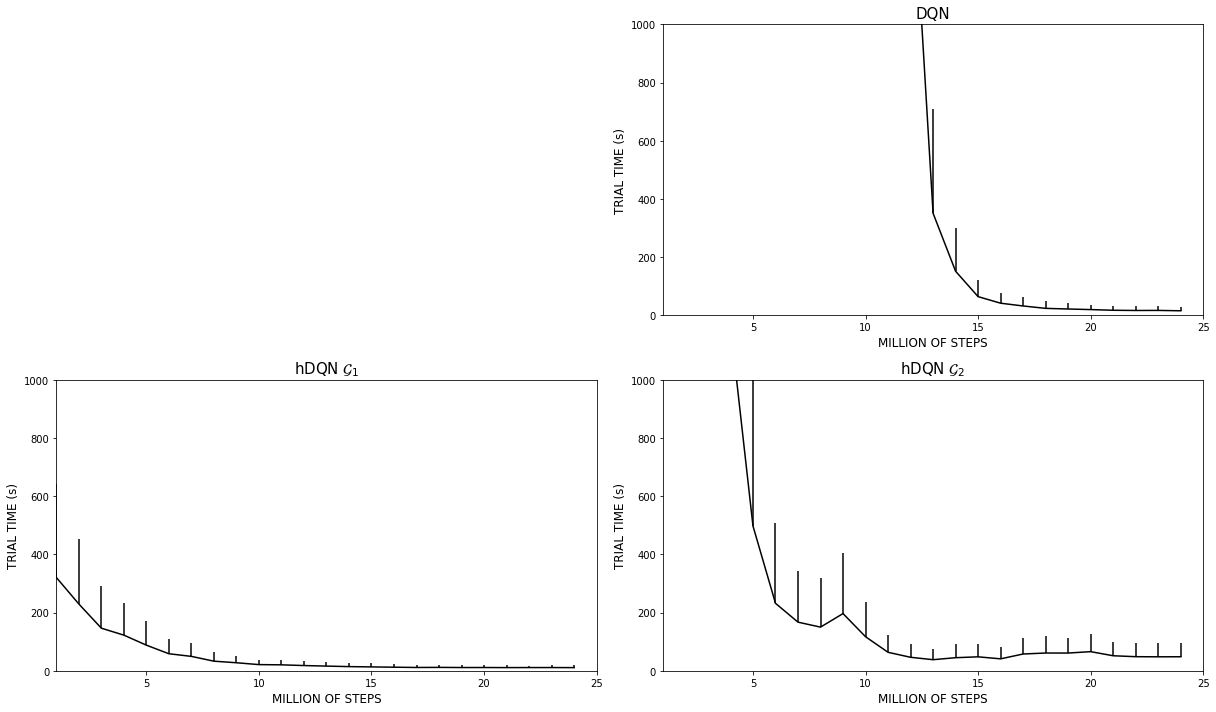

In [67]:
plt.figure(figsize = (17, 10))
for i in range(3):
    data = datas[i]
    means = data['means']
    stds = data['stds']
    run = data['run']
    plt.subplot(2, 2, 2 + i)
    neg_err = [0 for _ in stds]
    plt.errorbar(iterations, means, yerr = (neg_err, stds), color = 'black')
    plt.ylabel("TRIAL TIME (s)", fontsize = int(fontsize * .8))
    plt.xlabel("MILLION OF STEPS", fontsize = int(fontsize * .8))
    if 'atdqn' in run:
        title = 'DQN'
    elif 'gg3' in run:
        title = 'hDQN $\mathcal{G}_1$'
    elif 'gg4' in run:
        title = 'hDQN $\mathcal{G}_2$'
    plt.ylim([0, 1000])
    plt.xlim([1, 25])
    plt.title(title, fontsize = fontsize)
plt.tight_layout()
plt.show()

## Sparse / Dense rewards

In [20]:
experiment_folder = '/vol/tensusers/vgarciacazorla/logs/30d16h39m42s_sparse_exp'
data = {'sr0' : {}, 'sr1' : {}}
for dense in data.keys():
    folder_keyss = [folder_keys + [dense] for folder_keys in [['hdqn', 'gg3'], ['atdqn'], ['hdqn', 'gg4']]]
    for folder_keys in folder_keyss:
        config_key = '-'.join(folder_keys)
        data[dense][config_key] = {}
        reward_scalar_key = 'mc_total_reward' if 'hdqn' in folder_keys else '/total_reward'
        scalar_keys = [reward_scalar_key, 'wins', 'win_rate']
        for scalar_key in scalar_keys:
            values = get_all_series_averaged(folder_keys = folder_keys,
                                       scalar_key = scalar_key,
                                       experiment_folder = experiment_folder,
                                       steps_mode = steps_mode)
            scalar_key_ = scalar_key if 'total_reward' not in scalar_key else 'total_reward'
            data[dense][config_key][scalar_key_] = values


Searching for folder_keys='['hdqn', 'gg3', 'sr0']' in /vol/tensusers/vgarciacazorla/logs/30d16h39m42s_sparse_exp
	Got 2497 of scalar 'mc_total_reward' (0 errors)
	Got 2498 of scalar 'mc_total_reward' (0 errors)
	Got 2498 of scalar 'mc_total_reward' (0 errors)
	Got 2499 of scalar 'mc_total_reward' (0 errors)
	Got 2499 of scalar 'mc_total_reward' (0 errors)
Searching for folder_keys='['hdqn', 'gg3', 'sr0']' in /vol/tensusers/vgarciacazorla/logs/30d16h39m42s_sparse_exp
	Got 2496 of scalar 'wins' (0 errors)
	Got 2497 of scalar 'wins' (0 errors)
	Got 2497 of scalar 'wins' (0 errors)
	Got 2498 of scalar 'wins' (0 errors)
	Got 2498 of scalar 'wins' (0 errors)
Searching for folder_keys='['hdqn', 'gg3', 'sr0']' in /vol/tensusers/vgarciacazorla/logs/30d16h39m42s_sparse_exp
	Got 2496 of scalar 'win_rate' (0 errors)
	Got 2497 of scalar 'win_rate' (0 errors)
	Got 2497 of scalar 'win_rate' (0 errors)
	Got 2498 of scalar 'win_rate' (0 errors)
	Got 2498 of scalar 'win_rate' (0 errors)
Searching for fo

sr0
sr1


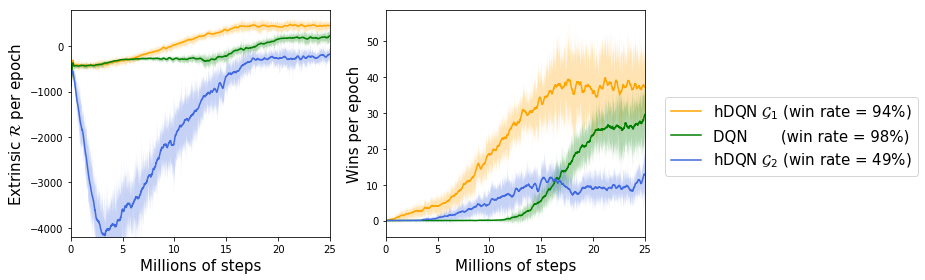

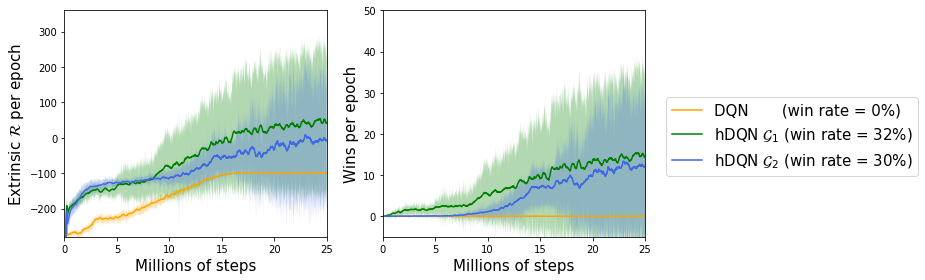

In [21]:
label_pairs = [('total_reward', 'Extrinsic $\mathcal{R}$ per epoch'), ('wins', 'Wins per epoch')]
colors = ['orange', 'green', 'royalblue']
aux = 1 # Set to 0 to get raw plots witout means +- std
for dense in data.keys():
    print(dense)
    plt.figure(figsize = (13, 4))
    scalar_keys = ['total_reward', 'wins']
    for i, (scalar_key, ylabel) in enumerate(label_pairs):
        plt.subplot(1, 2, i + 1)
        
        for config_key, color in zip(data[dense].keys(), colors):
            win_rates = data[dense][config_key]['win_rate']
            win_rate = int(win_rates['means'][-50:].mean() * 100)
            part_pairs = [('atdqn', 'DQN      '), ('gg4', 'hDQN $\mathcal{G}_2$'), ('gg3', 'hDQN $\mathcal{G}_1$')]            
            for key_part, label_part in part_pairs:
                if key_part in config_key:
                    label = '%s (win rate = %d%%)' % (label_part, win_rate)
                    break
            data_series = data[dense][config_key][scalar_key]
            if aux:
                custom_subplot(data_series, label, time = 0, logscale = False, color = color)
            if dense == 'sr1':
                for raw in data_series['raw']:
                    if aux:
                        break
                    plt.plot(data_series['steps'], raw, color = color, linewidth = 1, label = label)
        plt.ylabel(ylabel, fontsize = fontsize)
        plt.xlabel("Millions of steps", fontsize = fontsize)
        
        if scalar_key == 'total_reward' and dense == 'sr1':
            plt.ylim([-280, 360])
        if scalar_key == 'wins' and dense == 'sr1':
            plt.ylim([-5, 50])
        if scalar_key == 'total_reward' and dense == 'sr0':
            plt.ylim([-4200, 800])
        plt.xlim([0, 25])
        
 

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), fontsize = fontsize,
                bbox_to_anchor = (1.05, .65))
    plt.tight_layout()
    #plt.show()
    plt.savefig("img_%s_%d.jpg" % (dense, aux), dpi = 140)

## Key MDP

In [47]:

experiment_folder = '/mnt/data_disk/Hierarchical-DRL-Tensorflow/Others/logs/17d18h46m53s_key_exp'
labels = ['Double DQN', 'Vanilla DQN', 'Vanilla hDQN']
folder_keyss = [['atdqn', 'dq1'], ['atdqn', 'dq0'], ['hdqn']]
# Avg ep rewards
data_rewards = []
data_steps = []
for folder_keys in folder_keyss:
    reward_scalar_key = 'mc_avg_ep_reward' if 'hdqn' in folder_keys else 'avg_ep_reward'
    step_scalar_key = '/c_steps_per_episode' if 'hdqn' in folder_keys else 'steps_per_episode'
    data_reward = get_all_series_averaged(folder_keys = folder_keys,
                                   scalar_key = reward_scalar_key,
                                   experiment_folder = experiment_folder,
                                   steps_mode = steps_mode)
    data_rewards.append(data_reward)
    data_step = get_all_series_averaged(folder_keys = folder_keys,
                                   scalar_key = step_scalar_key,
                                   experiment_folder = experiment_folder,
                                   steps_mode = steps_mode)
    data_steps.append(data_step)
    
    


Searching for folder_keys='['atdqn', 'dq1']'
	Got 498 of avg_ep_reward (0 errors)
	Got 498 of avg_ep_reward (1 errors)
Searching for folder_keys='['atdqn', 'dq1']'
	Got 498 of steps_per_episode (0 errors)
	Got 498 of steps_per_episode (1 errors)
Searching for folder_keys='['atdqn', 'dq0']'
	Got 499 of avg_ep_reward (1 errors)
	Got 499 of avg_ep_reward (1 errors)
Searching for folder_keys='['atdqn', 'dq0']'
	Got 499 of steps_per_episode (1 errors)
	Got 499 of steps_per_episode (1 errors)
Searching for folder_keys='['hdqn']'
	Got 499 of mc_avg_ep_reward (1 errors)
	Got 499 of mc_avg_ep_reward (1 errors)
Searching for folder_keys='['hdqn']'
	Got 498 of /c_steps_per_episode (1 errors)
	Got 498 of /c_steps_per_episode (1 errors)


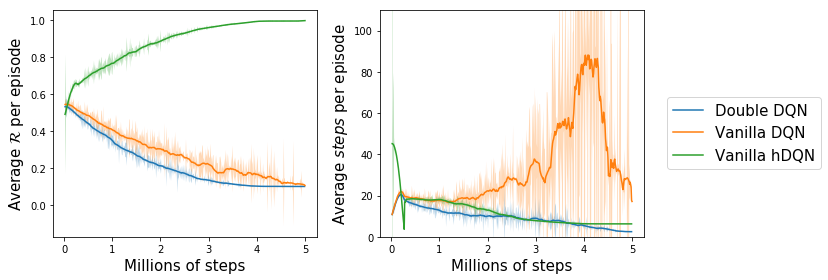

In [92]:
plt.figure(figsize = (12, 4))
plt.subplot(1, 2, 1)
for data_reward, label in zip(data_rewards, labels):
    custom_subplot(data_reward, label, time = False)
plt.ylabel('Average $\mathcal{R}$ per episode', fontsize = fontsize)
plt.xlabel("Millions of steps", fontsize = fontsize)
plt.subplot(1, 2, 2)
for data_step, label in zip(data_steps, labels):
    custom_subplot(data_step, label, time = False, logscale = 0)
    plt.ylim([0, 110])
plt.ylabel('Average $steps$ per episode', fontsize = fontsize)
plt.xlabel("Millions of steps", fontsize = fontsize)
plt.legend(fontsize = fontsize,
            bbox_to_anchor=(1.7, .65))
plt.tight_layout()
plt.show()

In [109]:
experiment_folder = '/mnt/data_disk/Hierarchical-DRL-Tensorflow/Others/logs/17d18h46m53s_key_exp'
folder_keys = ['hdqn']
goals = list(range(9))
datas = []
for goal in goals:
    scalar_key = 'g%d_rfreq' % goal    
    data = get_all_series_averaged(folder_keys = folder_keys,
                                   scalar_key = scalar_key,
                                   experiment_folder = experiment_folder,
                                   steps_mode = steps_mode)
    datas.append(data)

Searching for folder_keys='['hdqn']'
	Got 499 of g0_rfreq (1 errors)
	Got 499 of g0_rfreq (1 errors)
Searching for folder_keys='['hdqn']'
	Got 499 of g1_rfreq (1 errors)
	Got 499 of g1_rfreq (1 errors)
Searching for folder_keys='['hdqn']'
	Got 499 of g2_rfreq (1 errors)
	Got 499 of g2_rfreq (1 errors)
Searching for folder_keys='['hdqn']'
	Got 499 of g3_rfreq (1 errors)
	Got 499 of g3_rfreq (1 errors)
Searching for folder_keys='['hdqn']'
	Got 499 of g4_rfreq (1 errors)
	Got 499 of g4_rfreq (1 errors)
Searching for folder_keys='['hdqn']'
	Got 499 of g5_rfreq (1 errors)
	Got 499 of g5_rfreq (1 errors)
Searching for folder_keys='['hdqn']'
	Got 499 of g6_rfreq (1 errors)
	Got 499 of g6_rfreq (1 errors)
Searching for folder_keys='['hdqn']'
	Got 499 of g7_rfreq (1 errors)
	Got 499 of g7_rfreq (1 errors)
Searching for folder_keys='['hdqn']'
	Got 499 of g8_rfreq (1 errors)
	Got 501 of g8_rfreq (1 errors)


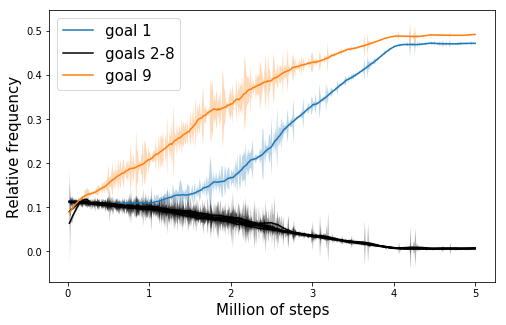

In [134]:
from collections import OrderedDict
plt.figure(figsize = (8, 5))
for data in datas:
    goal = int(data['scalar_key'][1]) + 1
    label = "goal %d" % goal if goal in [1, 9] else "goals 2-8"
    color = None if goal in [1, 9] else 'black'
    custom_subplot(data, label, time = False, logscale = 0, color = color)
plt.ylabel("Relative frequency", fontsize = fontsize)
plt.xlabel("Million of steps", fontsize = fontsize)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), fontsize = fontsize)
plt.show()

### h-DQN ablation of extensions

In [2]:
def get_folder_keys(target_module, ablation):
    folder_keys = []
    for module in module_keys:        
        for extension in extensions.keys():
            activated = int(ablation != extension or module != target_module)
            if ablation == 'all':
                activated = 0
            folder_key = "_%s%s%d_" % (module, extension, activated)
            folder_keys.append(folder_key)
    return folder_keys
module_keys = ['C', 'MC']
extensions = {'dq'  : 'Double Q',
              'd'   : 'Dueling',
              'p'   : 'Prioritized Replay',
              'None': 'Rainbow',
              'All' : 'Vanilla'}

In [3]:

print(get_folder_keys('MC', 'None'))

['_Cd1_', '_Cp1_', '_Cdq1_', '_CAll1_', '_CNone1_', '_MCd1_', '_MCp1_', '_MCdq1_', '_MCAll1_', '_MCNone0_']


In [4]:
def get_folder_keys(target_module, ablation):
    folder_keys = []
    for module in module_keys:        
        for extension in extensions.keys():
            activated = int(ablation != extension or module != target_module)
            if ablation == 'all':
                activated = 0
            folder_key = "_%s%s%d_" % (module, extension, activated)
            folder_keys.append(folder_key)
    return folder_keys
module_keys = ['C', 'MC']
debug = 0
extensions = {'dq'  : 'Double Q',
              'd'   : 'Dueling',
              'p'   : 'Prioritized Replay'}
datass = []
experiment_folder = '/vol/tensusers/vgarciacazorla/logs/30d15h58m09s_ablation_exp'#18d23h08m50s_ablation_exp/
for module in module_keys:
    datas = []
    scalar_key = '/%s_total_reward' % module.lower()
    for ablation in list(extensions.keys()) + [None, 'all']:
        folder_keys = get_folder_keys(module, ablation)
        
        data = get_all_series_averaged(folder_keys = folder_keys,
                                       scalar_key = scalar_key,
                                       experiment_folder = experiment_folder,
                                       steps_mode = steps_mode)
        datas.append(data)
    
    datass.append(datas)    


Searching for folder_keys='['_Cd0_', '_Cp1_', '_Cdq1_', '_MCd1_', '_MCp1_', '_MCdq1_']' in /vol/tensusers/vgarciacazorla/logs/30d15h58m09s_ablation_exp
	Got 1975 of scalar '/c_total_reward' (0 errors)
	Not finished (length = 1975) 
	Got 1972 of scalar '/c_total_reward' (0 errors)
	Not finished (length = 1972) 
	Got 2052 of scalar '/c_total_reward' (0 errors)
	Not finished (length = 2052) 
	Got 1974 of scalar '/c_total_reward' (0 errors)
	Not finished (length = 1974) 
	Got 1899 of scalar '/c_total_reward' (0 errors)
	Not finished (length = 1899) 
Searching for folder_keys='['_Cd1_', '_Cp0_', '_Cdq1_', '_MCd1_', '_MCp1_', '_MCdq1_']' in /vol/tensusers/vgarciacazorla/logs/30d15h58m09s_ablation_exp
	Got 2153 of scalar '/c_total_reward' (0 errors)
	Not finished (length = 2153) 
	Got 2221 of scalar '/c_total_reward' (0 errors)
	Not finished (length = 2221) 
	Got 2157 of scalar '/c_total_reward' (0 errors)
	Not finished (length = 2157) 
	Got 2220 of scalar '/c_total_reward' (0 errors)
	Not fi

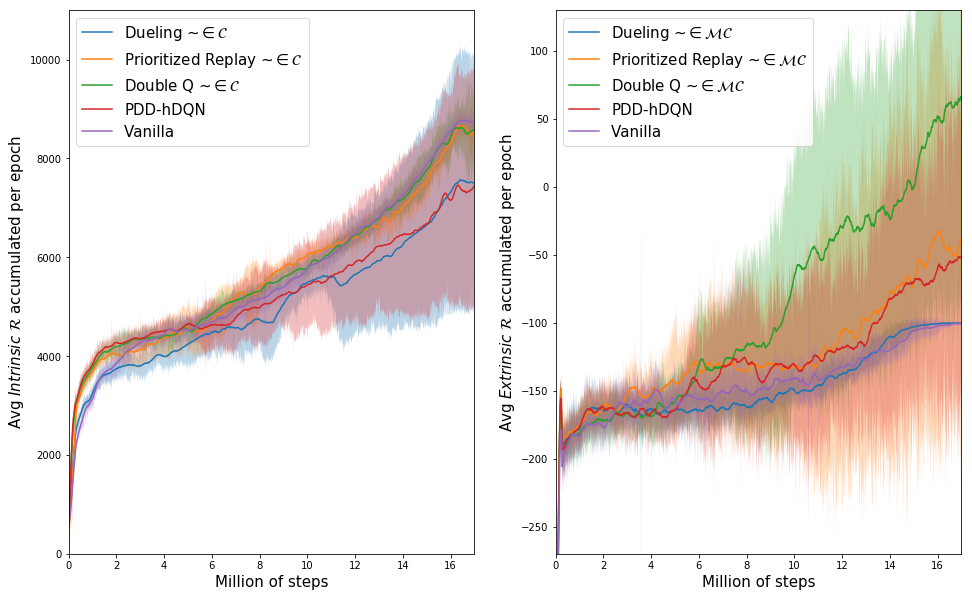

In [18]:
plt.figure(figsize = (16, 10))
total_figures = 2
rewards = ['$Intrinsic$', '$Extrinsic$']
y_limits = [[0, 11000], [-270, 130]]
for i in range(total_figures):
    module = module_keys[i]
    datas = datass[i]
    plt.subplot(1, 2, i + 1)
    for data in datas:
        if all(['0' in fk for fk in data['folder_keys']]):
            label = 'Vanilla'
        elif all(['1' in fk for fk in data['folder_keys']]):
            label = 'PDD-hDQN'
        else:
            ablation = [fk for fk in data['folder_keys'] if '0' in fk][0][1:-2].replace(module, '')
            label = "%s ~$\in\mathcal{%s}$" % (extensions[ablation], module)
        custom_subplot(data, label, time = 0)  
    plt.xlabel("Million of steps", fontsize = fontsize)
    plt.ylabel("Avg %s $\mathcal{R}$ accumulated per epoch" % rewards[i], fontsize = fontsize)
    plt.ylim(y_limits[i])
    plt.xlim([0, 17])
    plt.legend(fontsize = fontsize)
# plt.tight_layout()
plt.savefig('ablation_sparse', dpi = 150)
#plt.show()
    
    
    

### Goals and action repeat

In [27]:
experiment_folder = '/vol/tensusers/vgarciacazorla/logs/13d23h46m56s_goals_exp'
steps_mode = 'millions'  
action_repeats = [1, 3, 5]
datass = []
goal_groups = [0, 1, 2]

for gg in goal_groups:
    datas = []
    for ar in action_repeats:
        folder_keys = ['_ar%d_' % ar]
        if gg != 0:
            folder_keys.append("gg%d" % gg)
            scalar_key = 'mc_total_reward'
        else:
            folder_keys.append("atdqn")
            scalar_key = 'total_reward'
        scalar_key = 'win_rate'
        data = get_all_series_averaged(folder_keys = folder_keys,
                                       scalar_key = scalar_key,
                                       experiment_folder = experiment_folder,
                                       steps_mode = steps_mode)
        datas.append(data)
    datass.append(datas)

Searching for folder_keys='['_ar1_', 'atdqn']'
	Getting win_rate
	Getting win_rate
	Getting win_rate
Searching for folder_keys='['_ar3_', 'atdqn']'
	Getting win_rate
	Getting win_rate
	Getting win_rate
Searching for folder_keys='['_ar5_', 'atdqn']'
	Getting win_rate
	Getting win_rate
	Getting win_rate
Searching for folder_keys='['_ar1_', 'gg1']'
	Getting win_rate
	Getting win_rate
	Not finished (length = 994) 
	Getting win_rate
	Not finished (length = 993) 
Searching for folder_keys='['_ar3_', 'gg1']'
	Getting win_rate
	Not finished (length = 994) 
	Getting win_rate
	Not finished (length = 901) 
	Getting win_rate
	Not finished (length = 979) 
Searching for folder_keys='['_ar5_', 'gg1']'
	Getting win_rate
	Not finished (length = 900) 
	Getting win_rate
	Not finished (length = 940) 
	Getting win_rate
	Not finished (length = 877) 
Searching for folder_keys='['_ar1_', 'gg2']'
	Getting win_rate
	Getting win_rate
	Getting win_rate
Searching for folder_keys='['_ar3_', 'gg2']'
	Getting win_rat

### Intrinsic reward time penalty

In [69]:
experiment_folder = '/vol/tensusers/vgarciacazorla/logs/13d23h47m00s_intrinsic_exp'
steps_mode = 'millions'   
labels = ['With time penalty', 'Without time penalty']
cits = [ 'Citp0.01',  'Citp0_']
datass = []
goal_groups = [1, 2]
for gg in goal_groups:
    goals = CT.goal_groups['SF-v0'][gg]
    for goal in goals:
        datas = []
        scalar_key = '%s_avg_steps' % goal
        for cit in cits:
            folder_keys = ["gg%d" % gg, cit]
            data = get_all_series_averaged(folder_keys = folder_keys,
                                           scalar_key = scalar_key,
                                           experiment_folder = experiment_folder,
                                           steps_mode = steps_mode)
            datas.append(data)
        datass.append(datas)

Searching for folder_key='['gg1', 'Citp0.01']'
	Getting G_aim_at_fortress_avg_steps
	Getting G_aim_at_fortress_avg_steps
	Getting G_aim_at_fortress_avg_steps
Searching for folder_key='['gg1', 'Citp0_']'
	Getting G_aim_at_fortress_avg_steps
	Getting G_aim_at_fortress_avg_steps
	Getting G_aim_at_fortress_avg_steps
Searching for folder_key='['gg1', 'Citp0.01']'
	Getting G_aim_at_mine_avg_steps
	Getting G_aim_at_mine_avg_steps
	Getting G_aim_at_mine_avg_steps
Searching for folder_key='['gg1', 'Citp0_']'
	Getting G_aim_at_mine_avg_steps
	Getting G_aim_at_mine_avg_steps
	Getting G_aim_at_mine_avg_steps
Searching for folder_key='['gg1', 'Citp0.01']'
	Getting G_double_shoot_avg_steps
	Getting G_double_shoot_avg_steps
	Getting G_double_shoot_avg_steps
Searching for folder_key='['gg1', 'Citp0_']'
	Getting G_double_shoot_avg_steps
	Getting G_double_shoot_avg_steps
	Getting G_double_shoot_avg_steps
Searching for folder_key='['gg1', 'Citp0.01']'
	Getting G_single_shoot_avg_steps
	Getting G_single_s

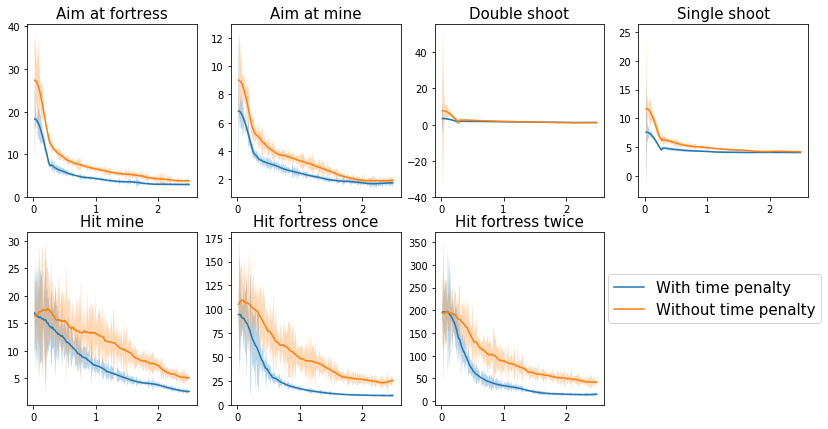

In [76]:
plt.figure(figsize = (14, 7))
columns = 4
rows = 2
total_figures = columns * rows
for i in range(total_figures - 1):
    plot_pos = i + 1
    plt.subplot(rows, columns, plot_pos)
    datas = datass[i]
    for data, label in zip(datas, labels):
        custom_subplot(data, label, time = False)
    title = data['scalar_key'][2:-10].replace('_', ' ').capitalize()
    plt.title(title, fontsize = fontsize)
    if i == total_figures - 2:
        plt.legend(fontsize = fontsize,
                   bbox_to_anchor=(2.32, .8))
        
    
plt.show()

### Action repeat

In [11]:
experiment_folder = '/vol/tensusers/vgarciacazorla/logs/04d09h25m33s_action_repeat_exp'
actions_repeats = list(range(1, 8))
labels = ["ar=%d" % ar for ar in actions_repeats]
folder_keys = ["ar%d_" % ar for ar in actions_repeats]
scalar_key = 'win_rate'
datas = get_datas(folder_keys, scalar_key, experiment_folder, steps_mode)

Searching for folder_key='ar1_'
	Getting win_rate from d04d09h25m33s_gg4_enSF-v0_e1_ma1_athdqn_a512-512_dq0_d0_p0_ar1_rs2
	Not finished
	Getting win_rate from d04d09h25m33s_gg4_enSF-v0_e1_ma1_athdqn_a512-512_dq0_d0_p0_ar1_rs1
	Not finished
	Getting win_rate from d04d09h25m33s_gg4_enSF-v0_e1_ma1_athdqn_a512-512_dq0_d0_p0_ar1_rs0
	Not finished
	Getting win_rate from d04d09h25m33s_gg4_enSF-v0_e1_ma1_athdqn_a512-512_dq0_d0_p0_ar1_rs3
	Not finished
Searching for folder_key='ar2_'
	Getting win_rate from d04d09h25m33s_gg4_enSF-v0_e1_ma1_athdqn_a512-512_dq0_d0_p0_ar2_rs3
	Not finished
	Getting win_rate from d04d09h25m33s_gg4_enSF-v0_e1_ma1_athdqn_a512-512_dq0_d0_p0_ar2_rs1
	Not finished
	Getting win_rate from d04d09h25m33s_gg4_enSF-v0_e1_ma1_athdqn_a512-512_dq0_d0_p0_ar2_rs0
	Not finished
	Getting win_rate from d04d09h25m33s_gg4_enSF-v0_e1_ma1_athdqn_a512-512_dq0_d0_p0_ar2_rs2
	Not finished
Searching for folder_key='ar3_'
	Getting win_rate from d04d09h25m33s_gg4_enSF-v0_e1_ma1_athdqn_a512-512_

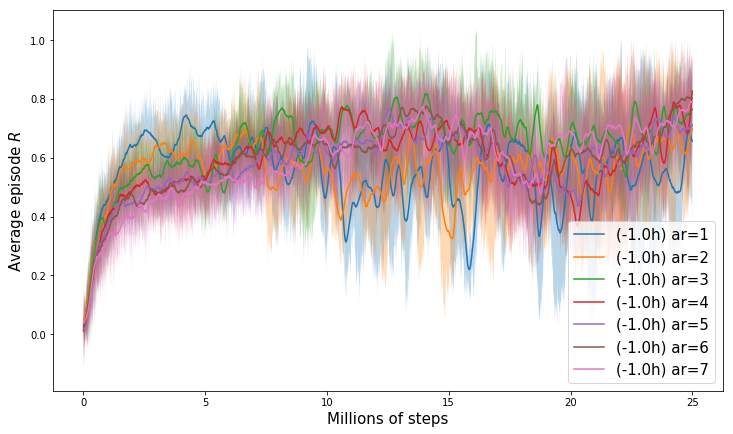

In [12]:
make_plot(datas, labels)

### Architectures

In [ ]:
experiment_folder = '/vol/tensusers/vgarciacazorla/logs/21d18h32m35s_architectures_exp'
architectures = [[16],
                [64, 64],
                [64, 64, 64, 64],
                [512],
                [512, 512],
                [512, 512, 512, 512]]
labels = ['-'.join([str(n) for n in a]) for a in architectures]
folder_keys = ['a' + l + '_' for l in labels]
datas = get_datas(folder_keys, scalar_key, experiment_folder, steps_mode)

### Architectures h-DQN

In [13]:
experiment_folder = '/vol/tensusers/vgarciacazorla/logs/04d09h25m40s_architectures_exp'
architectures = [[16],
                [64],
                [64, 64],
                [64, 64, 64, 64],
                [512],
                [512, 512],
                [512, 512, 512, 512]]
scalar_key = 'win_rate'
labels = ['-'.join([str(n) for n in a]) for a in architectures]
folder_keys = ['a' + l + '_' for l in labels]
datas = get_datas(folder_keys, scalar_key, experiment_folder, steps_mode)

Searching for folder_key='a16_'
	Getting win_rate from d04d09h25m40s_gg4_enSF-v0_e0_ma1_athdqn_a16_dq0_d0_p0_ar6_rs1
	Not finished
	Getting win_rate from d04d09h25m40s_gg4_enSF-v0_e0_ma1_athdqn_a16_dq0_d0_p0_ar6_rs2
	Not finished
	Getting win_rate from d04d09h25m40s_gg4_enSF-v0_e0_ma1_athdqn_a16_dq0_d0_p0_ar6_rs3
	Not finished
	Getting win_rate from d04d09h25m40s_gg4_enSF-v0_e0_ma1_athdqn_a16_dq0_d0_p0_ar6_rs0
	Not finished
Searching for folder_key='a64_'
	Getting win_rate from d04d09h25m40s_gg4_enSF-v0_e0_ma1_athdqn_a64_dq0_d0_p0_ar6_rs3
	Not finished
	Getting win_rate from d04d09h25m40s_gg4_enSF-v0_e0_ma1_athdqn_a64_dq0_d0_p0_ar6_rs2
	Not finished
	Getting win_rate from d04d09h25m40s_gg4_enSF-v0_e0_ma1_athdqn_a64_dq0_d0_p0_ar6_rs1
	Not finished
	Getting win_rate from d04d09h25m40s_gg4_enSF-v0_e0_ma1_athdqn_a64_dq0_d0_p0_ar6_rs0
	Not finished
Searching for folder_key='a64-64_'
	Getting win_rate from d04d09h25m40s_gg4_enSF-v0_e0_ma1_athdqn_a64-64_dq0_d0_p0_ar6_rs0
	Not finished
	Gettin